# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

### Contents:
- [Background](#Background)
- [Data](#Data)
- [Utilising adapted model](#Utilising-adapted-model)
- [AlexNet](#AlexNet)



In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Average, Input, Activation, Reshape, TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import models, layers, utils
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
pd.options.mode.chained_assignment = None  # default='warn'



**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):** 
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports. 
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* valdation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data import

**import data and get labels**

In [4]:
!unzip drive/My\ Drive/data.zip > /dev/null

In [5]:
train_path = 'data/train/'
valid_path = 'data/valid/'

In [6]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['axial', 'coronal', 'sagittal']
# diagnosis = ['abnormal','meniscus','acl']

In [7]:
def get_data(dataset_type, plane, diagnosis):
    '''this function gets the data for each plane from original dataset'''
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path
        
#     img_path = glob(f'{go}/{plane}/*.npy')
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)
    
    # label_path = f'../data/{dataset_type}-{diagnosis}.csv'
    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, plane_dir, label_data)

**meniscus dataset**

In [8]:
# training data
train_coronal_data, train_coronal_dir, train_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_data, train_axial_dir, train_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_data, train_sagittal_dir, train_men_label = get_data('train', 'sagittal', 'meniscus')

In [9]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_men_label = get_data('valid','coronal','meniscus')
valid_axial_data, valid_axial_dir, valid_men_label = get_data('valid','axial','meniscus')
valid_sagittal_data, valid_sagittal_dir, valid_men_label = get_data('valid','sagittal','meniscus')

In [10]:
train_coronal_data[0]

'0415.npy'

In [11]:
train_coronal_dir

'data/train//coronal'

The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained. 
<br> Unfortunately, when using a pretrained model, one is limited by input_shape. For VGG16, it should be (224, 244, 3), or (3, 224, 224). It should be in 4D tensor with shape (batch_shape, conv_dim1, conv_dim2, channel).

In [12]:
def image_extraction(data, path, new_path): #3 images
    '''this function extracts middle 3 slides of each scan'''
    extract=[]
    new_data=[]
    for i in range(len(data)): 
        img = np.load(os.path.join(path,data[i]))
        middle_idx = int(img.shape[0]/2)
        img = img[(middle_idx - 1) : (middle_idx + 2)]
#         # reshape adapted for model (s x 256 x 256 x 1)
#         img = np.repeat(img[..., np.newaxis], 1, -1)
        img = img.reshape(256,256,3)
        extract.extend(img)
        new_data.append(np.array(extract))        
        extract.clear()
        
#     new_data.shape(1130, 256, 256, 3) for train
    np.save(new_path, np.array(new_data))


**image extraction for training data**

In [13]:
# image extraction for 3 planes
new_path = 'data/train_transform/coronal'
image_extraction(train_coronal_data, train_coronal_dir, new_path)

In [14]:
new_path = 'data/train_transform/axial'
image_extraction(train_axial_data, train_axial_dir, new_path)

In [15]:
new_path = 'data/train_transform/sagittal'
image_extraction(train_sagittal_data, train_sagittal_dir, new_path)

In [16]:
image = np.load('data/train_transform/sagittal.npy')

In [17]:
image[0].shape

(256, 256, 3)

**extraction for validation data**

In [18]:
# image extraction for 3 planes
new_path = 'data/valid_transform/coronal'
image_extraction(valid_coronal_data, valid_coronal_dir, new_path)

In [19]:
new_path = 'data/valid_transform/axial'
image_extraction(valid_axial_data, valid_axial_dir, new_path)

In [20]:
new_path = 'data/valid_transform/sagittal'
image_extraction(valid_sagittal_data, valid_sagittal_dir, new_path)

In [21]:
image = np.load('data/valid_transform/sagittal.npy')
image.shape

(120, 256, 256, 3)

**data generation for meniscus**

In [22]:
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data for each plane from extracted dataset'''
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = 'data/train_transform/'
    else:
        go = 'data/valid_transform/'
        
    plane_dir = f'{go}/{plane}.npy'
    
    data = np.load(plane_dir)
    # label_path = f'../data/{dataset_type}-{diagnosis}.csv'
    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, label_data)
    

In [23]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal', 'meniscus')

# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal', 'meniscus')

In [24]:
def plot_results(model):
    '''this function plots the results of the model'''
    train_loss = model.history['loss']
    test_loss = model.history['val_loss']
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    epoch_labels = model.epoch

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

    axes[0].plot(train_loss, label='Training Loss', color='#185fad')
    axes[0].plot(test_loss, label='Testing Loss', color='orange')

    axes[1].plot(acc, label='Training accuracy', color='blue')
    axes[1].plot(val_acc, label='Testing accuracy', color='red')

    # Set title
    axes[0].title.set_text('Training and Testing Loss by Epoch')
    axes[1].title.set_text('Training and Testing Accuracy by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')
    axes[0].set_ylabel('Binary Crossentropy')
    axes[1].set_ylabel('Binary Crossentropy')
    plt.xticks(epoch_labels, epoch_labels);    
    axes[0].legend(fontsize=18);
    axes[1].legend(fontsize=18);


## Utilising adapted model

### AlexNet
The below is adapted from [AlexNet](https://neurohive.io/en/popular-networks/alexnet-imagenet-classification-with-deep-convolutional-neural-networks/) which won the 2012 ImageNet LSVRC-2012 competition, and which was also the primary building block for the Stanford group that analysed this data. It is a lot 'smaller', with reduced number of filters and neurons in the connected layers to minimise overfitting.
<br>
<br> Added 'same' padding, so that output size is the same as input size. This requires the filter window to slip outside input map, hence the need to pad. 
<br>
<br> BatchNormalisation layer was initially added because it would accelerate the training process, while offering similar classification accuracy and provide a modest form of regularization. However, due to the small batch_size used, this was replaced with the kernel_regularizer. Furthermore, it was found that normalisation together with regularisation has no effect on regularising the network ([Laarhoven 2017](https://arxiv.org/pdf/1706.05350.pdf)), so only one (normalisation or regularisation) was needed. Regularisation l2 (sum of squared weights) was chosen because it was the most common type (with values in the log scale), with reasonable values of lambda range between 0 and 0.1 (Applied Predictive Modeling, 2013). After several increments from 1e-6 and considering the tendency for overfitting, the value of 1e-3 was used. A higher value (such as 0.01) will lead to underfitting, so learning rate of sgd was decreased.
<br>
<br> 'sgd' was used so that the learning rate will be slow, and '1e-5' was found to allow a slower learning. Too high and it was overfitting/ underfitting within 1-2 epochs.  

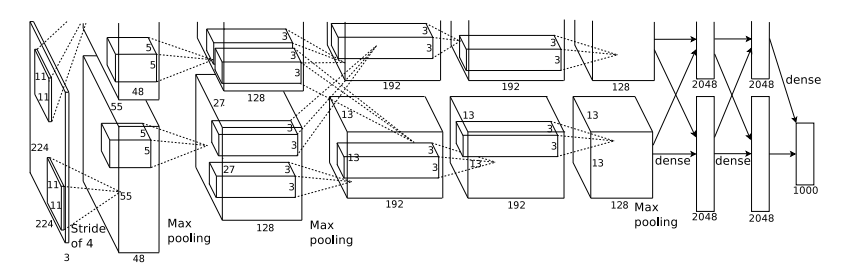

In [1119]:
def create_model():
    '''this function creates the model adapted from alexnet'''
    # instantiate
    cnn_model = Sequential()

    # 1st layer
    cnn_model.add(Conv2D(filters = 6,             # number of filters
                         kernel_size = (11, 11),   # height/width of filter
                         activation='relu',        # activation function 
                         input_shape=(256,256,3),  # shape of input (image)
                         strides=(4,4),
                         kernel_regularizer=l2(1e-3),
                         padding='same')) 
    
    # Max pooling
    cnn_model.add(MaxPooling2D(pool_size=(3,3),
                              strides=(2,2),
                              padding='same'))

    # 2nd layer
    cnn_model.add(Conv2D(filters = 16,             
                         kernel_size = (5, 5),   
                         activation='relu',       
                         strides=(1,1),
                         kernel_regularizer=l2(1e-3),
                         padding='same')) 

    # Max pooling
    cnn_model.add(MaxPooling2D(pool_size=(3,3),
                              strides=(2,2),
                              padding='same'))

    # 3rd layer
    cnn_model.add(Conv2D(filters = 32,             
                         kernel_size = (3, 3),   
                         activation='relu',       
                         strides=(1,1),
                         kernel_regularizer=l2(1e-3),
                         padding='same')) 

    # 4th layer
    cnn_model.add(Conv2D(filters = 64,             
                         kernel_size = (3, 3),   
                         activation='relu',       
                         strides=(1,1),
                         kernel_regularizer=l2(1e-3),
                         padding='same')) 

    # 5th layer
    cnn_model.add(Conv2D(filters = 32,             
                         kernel_size = (3, 3),   
                         activation='relu',       
                         strides=(1,1),
                         padding='same')) 
    cnn_model.add(BatchNormalization())

    # Max pooling
    cnn_model.add(MaxPooling2D(pool_size=(3,3),
                              strides=(2,2),
                              padding='same'))
    
    # flatten from box to vertical line of nodes!
    cnn_model.add(Flatten())
    
    # 1st fully connected layer
    cnn_model.add(Dense(16, activation='relu',kernel_regularizer=l2(1e-3)))
    
    # To avoid overfitting!
    cnn_model.add(Dropout(0.5))
    
    # 2nd fully connected layer
    cnn_model.add(Dense(8, activation='relu',kernel_regularizer=l2(1e-3)))
    
    # To avoid overfitting!
    cnn_model.add(Dropout(0.5))
    
    # Add a final layer with 1 neuron.
    cnn_model.add(Dense(1, activation='sigmoid')) 
    
    sgd = optimizers.SGD(learning_rate=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
    
    # Compile model 
    cnn_model.compile(loss='binary_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

    return cnn_model

In [1120]:
model = create_model()
model.summary()


Model: "sequential_191"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_955 (Conv2D)          (None, 64, 64, 6)         2184      
_________________________________________________________________
max_pooling2d_573 (MaxPoolin (None, 32, 32, 6)         0         
_________________________________________________________________
conv2d_956 (Conv2D)          (None, 32, 32, 16)        2416      
_________________________________________________________________
max_pooling2d_574 (MaxPoolin (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_957 (Conv2D)          (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_958 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_959 (Conv2D)          (None, 16, 16, 32)     

In [1121]:
for layer in model.layers:
    layer.trainable = True
df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
df.style.applymap(lambda trainable: f'background-color: {"yellow" if trainable else "white"}', subset=['trainable'])

,layer,trainable
0,conv2d_955,True
1,max_pooling2d_573,True
2,conv2d_956,True
3,max_pooling2d_574,True
4,conv2d_957,True
5,conv2d_958,True
6,conv2d_959,True
7,batch_normalization_203,True
8,max_pooling2d_575,True
9,flatten_191,True


In [1122]:
def build_model(model,model_name, num_epochs, train_data, train_labels, validation_data, validation_labels):
    '''this function builds and runs the model'''
    path_dir = '/content/drive/MyDrive' 
    weights_path = f'{path_dir}/{model_name}/alexnet_weights.h5'
    checkpoint_path = f'{path_dir}/{model_name}//alexnet_model.h5'

    model.save_weights(weights_path)
        
    history = model.fit(x=train_data, y=np.array(train_labels), 
            batch_size=32, 
            validation_data=(validation_data, np.array(validation_labels)),
            epochs=num_epochs, 
            callbacks = [EarlyStopping(patience=2, monitor = 'val_loss', mode = 'min'),
                        ModelCheckpoint(filepath=checkpoint_path, monitor = 'val_loss', save_best_only=True)],                
            verbose=1)
    
    return model, history

batch_size at 32 was good. Too high, and the accuracy was fluctuating too much. patience was kept at 2, due to  overfitting very early during training. So it was better to stop it early, rather than have a higher value for patience. 

Epoch 1/20
36/36 [==============================] - 2s 34ms/step - loss: 1.0032 - accuracy: 0.5832 - val_loss: 0.8925 - val_accuracy: 0.5667
Epoch 2/20
36/36 [==============================] - 1s 22ms/step - loss: 0.8862 - accuracy: 0.5867 - val_loss: 0.8133 - val_accuracy: 0.5500
Epoch 3/20
36/36 [==============================] - 1s 22ms/step - loss: 0.8444 - accuracy: 0.5920 - val_loss: 0.7926 - val_accuracy: 0.5750
Epoch 4/20
36/36 [==============================] - 1s 23ms/step - loss: 0.8276 - accuracy: 0.5770 - val_loss: 0.7913 - val_accuracy: 0.5667
Epoch 5/20
36/36 [==============================] - 1s 23ms/step - loss: 0.8218 - accuracy: 0.5761 - val_loss: 0.7929 - val_accuracy: 0.5667
Epoch 6/20
36/36 [==============================] - 1s 23ms/step - loss: 0.8202 - accuracy: 0.6106 - val_loss: 0.7957 - val_accuracy: 0.5583


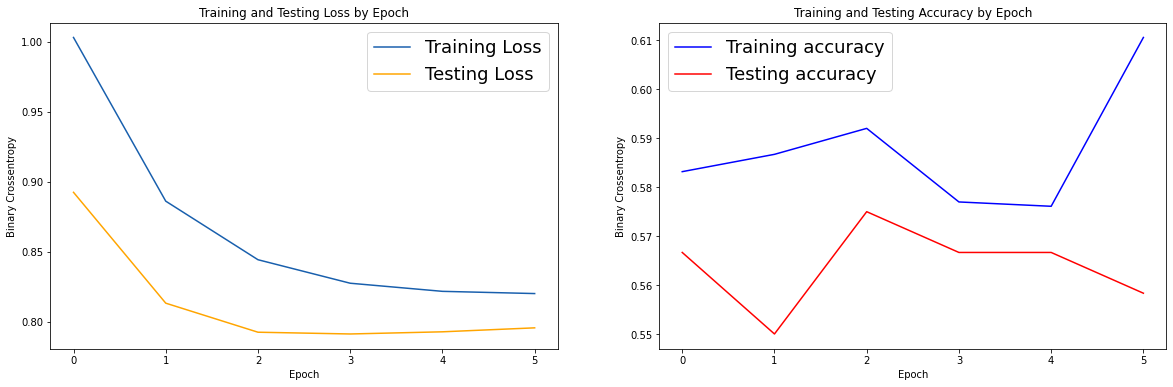

In [1123]:
# coronal plane
num_epochs=20

cnn_model=create_model()
cor_men_model, alex_cor_men = build_model(cnn_model,'alex_cor_men', num_epochs, coronal_mensicus, coronal_mensicus_label, coronal_mensicus_val, coronal_mensicus_label_val)

# get/plot accuracy
alex_cor_men_acc=[]
alex_cor_men_acc.append(np.mean(alex_cor_men.history['val_accuracy']))
plot_results(alex_cor_men)

Epoch 1/20
36/36 [==============================] - 2s 30ms/step - loss: 1.1554 - accuracy: 0.4504 - val_loss: 0.8693 - val_accuracy: 0.4250
Epoch 2/20
36/36 [==============================] - 1s 22ms/step - loss: 0.8779 - accuracy: 0.5088 - val_loss: 0.8297 - val_accuracy: 0.4250
Epoch 3/20
36/36 [==============================] - 1s 22ms/step - loss: 0.8581 - accuracy: 0.4965 - val_loss: 0.8247 - val_accuracy: 0.4250
Epoch 4/20
36/36 [==============================] - 1s 23ms/step - loss: 0.8421 - accuracy: 0.5407 - val_loss: 0.8207 - val_accuracy: 0.4167
Epoch 5/20
36/36 [==============================] - 1s 21ms/step - loss: 0.8456 - accuracy: 0.5080 - val_loss: 0.8185 - val_accuracy: 0.4250
Epoch 6/20
36/36 [==============================] - 1s 22ms/step - loss: 0.8364 - accuracy: 0.5283 - val_loss: 0.8169 - val_accuracy: 0.4500
Epoch 7/20
36/36 [==============================] - 1s 22ms/step - loss: 0.8340 - accuracy: 0.5407 - val_loss: 0.8158 - val_accuracy: 0.4667
Epoch 8/20
36

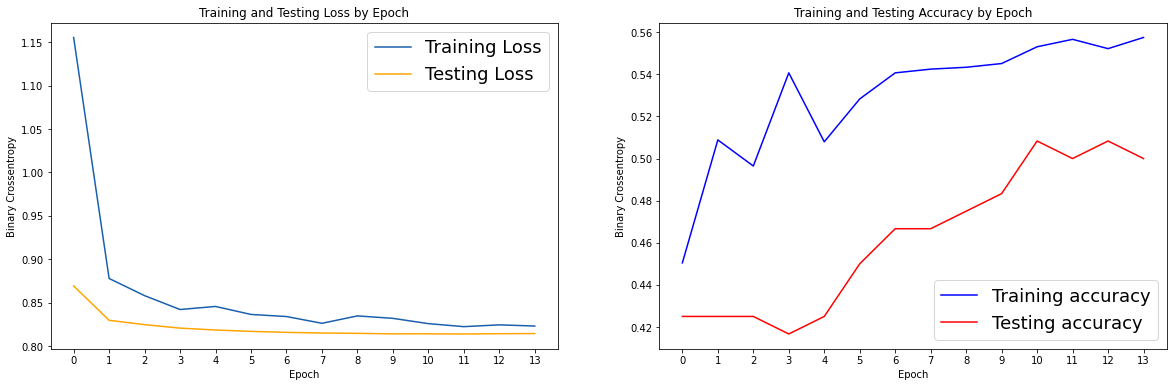

In [1124]:
# axial plane
num_epochs=20

cnn_model=create_model()
axl_men_model, alex_axl_men = build_model(cnn_model,'alex_axl_men', num_epochs, axial_mensicus, axial_mensicus_label, axial_mensicus_val, axial_mensicus_label_val)

# get/plot accuracy
alex_axl_men_acc=[]
alex_axl_men_acc.append(np.mean(alex_axl_men.history['val_accuracy']))
plot_results(alex_axl_men)

Epoch 1/20
36/36 [==============================] - 2s 33ms/step - loss: 1.6635 - accuracy: 0.4796 - val_loss: 1.0403 - val_accuracy: 0.4583
Epoch 2/20
36/36 [==============================] - 1s 21ms/step - loss: 0.9575 - accuracy: 0.5292 - val_loss: 0.8649 - val_accuracy: 0.4667
Epoch 3/20
36/36 [==============================] - 1s 22ms/step - loss: 0.8766 - accuracy: 0.5425 - val_loss: 0.8268 - val_accuracy: 0.5583
Epoch 4/20
36/36 [==============================] - 1s 22ms/step - loss: 0.8293 - accuracy: 0.5805 - val_loss: 0.8148 - val_accuracy: 0.5500
Epoch 5/20
36/36 [==============================] - 1s 22ms/step - loss: 0.8172 - accuracy: 0.5850 - val_loss: 0.8137 - val_accuracy: 0.5417
Epoch 6/20
36/36 [==============================] - 1s 22ms/step - loss: 0.8229 - accuracy: 0.6035 - val_loss: 0.8069 - val_accuracy: 0.5500
Epoch 7/20
36/36 [==============================] - 1s 21ms/step - loss: 0.8002 - accuracy: 0.6221 - val_loss: 0.8034 - val_accuracy: 0.5500
Epoch 8/20
36

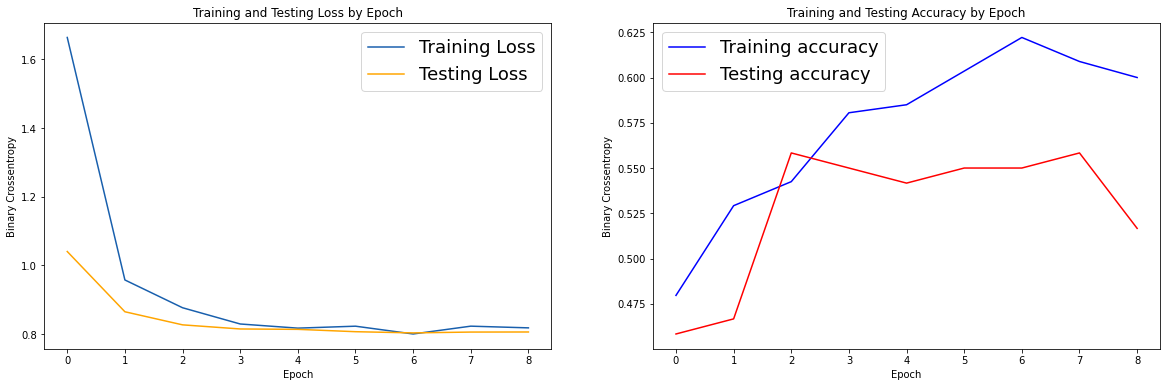

In [1125]:
# sagittal plane
num_epochs=20

cnn_model=create_model()
sag_men_model, alex_sag_men = build_model(cnn_model,'alex_sag_men', num_epochs, sagittal_mensicus, sagittal_mensicus_label, sagittal_mensicus_val, sagittal_mensicus_label_val)

# get/plot accuracy
alex_sag_men_acc=[]
alex_sag_men_acc.append(np.mean(alex_sag_men.history['val_accuracy']))
plot_results(alex_sag_men)

**calculate average accuracy**

In [1126]:
[alex_cor_men_acc, alex_axl_men_acc, alex_sag_men_acc]

[[0.5638888875643412], [0.46249999957425253], [0.527777784400516]]

### Evaluate results

In [1127]:
cor_men_scores = cor_men_model.evaluate(coronal_mensicus_val, np.array(coronal_mensicus_label_val), verbose=0)
print('Test loss:', cor_men_scores[0]) 
print('Test accuracy:', cor_men_scores[1])

Test loss: 0.795713484287262
Test accuracy: 0.5583333373069763


In [1128]:
axl_men_scores = axl_men_model.evaluate(axial_mensicus_val, np.array(axial_mensicus_label_val), verbose=0)
print('Test loss:', axl_men_scores[0]) 
print('Test accuracy:', axl_men_scores[1])

Test loss: 0.8144462704658508
Test accuracy: 0.5


In [1129]:
sag_men_scores = sag_men_model.evaluate(sagittal_mensicus_val, np.array(sagittal_mensicus_label_val), verbose=0)
print('Test loss:', sag_men_scores[0]) 
print('Test accuracy:', sag_men_scores[1])

Test loss: 0.8060425519943237
Test accuracy: 0.5166666507720947


In [1130]:
path_dir = '/content/drive/MyDrive' 
saved_cor_model = load_model(f'{path_dir}/alex_cor_men//alexnet_model.h5')
cor_pred = saved_cor_model.predict(coronal_mensicus_val) 

In [1131]:
saved_axl_model = load_model(f'{path_dir}/alex_axl_men//alexnet_model.h5')
axl_pred = saved_axl_model.predict(axial_mensicus_val) 

In [1132]:
saved_sag_model = load_model(f'{path_dir}/alex_sag_men//alexnet_model.h5')
sag_pred = saved_sag_model.predict(sagittal_mensicus_val)

In [1133]:
pred_men = pd.DataFrame(np.column_stack([cor_pred,axl_pred,sag_pred]),columns=['cor_pred', 'axl_pred', 'sag_pred'])
pred_men['mean'] = pred_men.mean(axis=1)

In [1134]:
# since model output is [0,1] using sigmoid activation function
# pred is the probability
# take average probability from all 3 planes
pred_men['mean']

0      0.446790
1      0.417211
2      0.438381
3      0.389491
4      0.464809
         ...   
115    0.478734
116    0.477266
117    0.483805
118    0.502009
119    0.477793
Name: mean, Length: 120, dtype: float32

In [1135]:
pred_men['mean'] = pred_men.mean(axis=1)

In [1136]:
# if prob<0.5, it is 0.
pred_men['predict'] = pred_men['mean'].map(lambda x: 0 if x<0.5 else 1)

In [1137]:
pred_men['predict'].value_counts()

0    116
1      4
Name: predict, dtype: int64

In [1138]:
# labels are same for all planes
pred_men['true'] = coronal_mensicus_label_val

In [1139]:
pred_men[pred_men['true'] != pred_men['predict']].shape

(52, 6)

In [1140]:
pred_men[pred_men['true'] != pred_men['predict']]

,cor_pred,axl_pred,sag_pred,mean,predict,true
33,0.478185,0.502052,0.583182,0.521140,1,0
41,0.554691,0.526574,0.497616,0.526294,1,0
42,0.370081,0.498020,0.466747,0.444949,0,1
43,0.407190,0.498020,0.431683,0.445631,0,1
44,0.372720,0.501129,0.514530,0.462793,0,1
46,0.457443,0.498020,0.456058,0.470507,0,1
54,0.467500,0.504368,0.442351,0.471407,0,1
56,0.368533,0.498020,0.421962,0.429505,0,1
58,0.348905,0.498020,0.510700,0.452542,0,1
61,0.465107,0.508167,0.404985,0.459419,0,1


**export results to csv**

In [1141]:
pred_men.to_csv('/content/drive/MyDrive/alexnet_pred_men_results.csv')